In [36]:
# %%
"""
Group03_RiskFactorsCervicalCancer_notebook.py

Author: Generated for Mushtaq Tiamoor Zeeshan (Group03)
"""

# %%
# 0. Setup: imports and configs
import os
import time
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score, recall_score, precision_score,
                             confusion_matrix, classification_report)

# imbalanced-learn
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE, RandomOverSampler
except Exception:
    raise ImportError('Please install imbalanced-learn: pip install imbalanced-learn')

import joblib
import matplotlib.pyplot as plt

# Save folders
OUT_DIR = Path('experiment_output')
OUT_DIR.mkdir(exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Put here the path to your dataset and the target column name
DATA_PATH = 'risk_factors_cervical_cancer.csv'  # <-- change if needed
TARGET_COL = 'Biopsy'  # <-- change to the true target column name in your file
ID_COL = None  # if there is an id column in dataset set name here, else None

# Utility for human-readable random number insertion preference (user preference in context)
def pretty_rand(n=6):
    """Return a human-readable random-ish integer string."""
    return f"rnd{int(abs(hash(time.time())) % (10**n))}"

# Helper: save experiment results to CSV incrementally
RESULTS_FILE = OUT_DIR / f"experiment_results_{pretty_rand(5)}.csv"
if not RESULTS_FILE.exists():
    pd.DataFrame(columns=['dataset','classifier','variant','params','cv_mean_roc_auc','cv_std_roc_auc',
                          'test_roc_auc','test_avg_precision','test_f1','test_recall','train_time_sec']).to_csv(RESULTS_FILE, index=False)


In [37]:
import os
import time
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report
)

# %%
# 1. Load & inspect data
print('Loading data from', DATA_PATH)
df = pd.read_csv(r"E:\DATASCIENCE\ML Datasets\risk_factors_cervical_cancer.csv")
print('Shape:', df.shape)
print('Columns:')
print(df.columns.tolist())

# Quick head
print('\nFirst 5 rows:')
print(df.head())

# Basic info
print('\nData types:')
print(df.dtypes)

# Basic missingness
print('\nMissing values per column:')
print(df.isna().sum())

# If ID_COL provided, drop from features later but preserve for submission
if ID_COL and ID_COL in df.columns:
    print(f'Detected ID column: {ID_COL}')

# Show target distribution
if TARGET_COL not in df.columns:
    raise ValueError(f'TARGET_COL {TARGET_COL} not found in dataframe columns')

print('\nTarget distribution:')
print(df[TARGET_COL].value_counts(dropna=False))


Loading data from risk_factors_cervical_cancer.csv
Shape: (858, 36)
Columns:
['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']

First 5 rows:
   Age Number of sexual partners First sexual intercourse Num of pregnancies  \
0   18                       4.0                     15.0                1.0   
1   15                     

In [4]:
# %%
# 2. Exploratory Data Analysis (EDA)
# (Run these cells to generate plots and summaries)

# Summary stats numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns:', numeric_cols)
print(df[numeric_cols].describe().T)

# Categorical columns
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
print('\nCategorical columns:', cat_cols)

# Visualizations (simple)
plt.figure(figsize=(8,4))
if TARGET_COL in df.columns and df[TARGET_COL].nunique() <= 10:
    df[TARGET_COL].value_counts().plot(kind='bar')
    plt.title('Target distribution')
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'target_distribution.png')
    plt.close()

# Missingness heatmap (simple)
plt.figure(figsize=(12,4))
plt.imshow(df.isna(), aspect='auto')
plt.xlabel('Columns')
plt.ylabel('Samples')
plt.title('Missingness matrix (blue=missing)')
plt.savefig(OUT_DIR / 'missingness_matrix.png')
plt.close()

# Correlation heatmap for numeric features (if not too many)
if len(numeric_cols) > 1 and len(numeric_cols) <= 40:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10,8))
    plt.imshow(corr, aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title('Numeric feature correlation (visual)')
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'numeric_correlation.png')
    plt.close()

# Save a CSV summary of missingness and basic stats
summary = pd.DataFrame({
    'column': df.columns,
    'dtype': df.dtypes.astype(str),
    'n_missing': df.isna().sum(),
    'n_unique': df.nunique()
})
summary.to_csv(OUT_DIR / 'column_summary.csv', index=False)
print('EDA artifacts saved to', OUT_DIR)



Numeric columns: ['Age', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']
                           count       mean       std   min   25%   50%   75%  \
Age                        858.0  26.820513  8.497948  13.0  20.0  25.0  32.0   
STDs: Number of diagnosis  858.0   0.087413  0.302545   0.0   0.0   0.0   0.0   
Dx:Cancer                  858.0   0.020979  0.143398   0.0   0.0   0.0   0.0   
Dx:CIN                     858.0   0.010490  0.101939   0.0   0.0   0.0   0.0   
Dx:HPV                     858.0   0.020979  0.143398   0.0   0.0   0.0   0.0   
Dx                         858.0   0.027972  0.164989   0.0   0.0   0.0   0.0   
Hinselmann                 858.0   0.040793  0.197925   0.0   0.0   0.0   0.0   
Schiller                   858.0   0.086247  0.280892   0.0   0.0   0.0   0.0   
Citology                   858.0   0.051282  0.220701   0.0   0.0   0.0   0.0   
Biopsy                     858.0   0.064103  0.2

In [11]:
# %%
# 3. Preprocessing pipelines & type detection
# Let user edit numeric/categorical lists if auto-detection is not perfect

# Recompute automatic typing but allow manual override by editing lists
numeric_features = numeric_cols.copy()
if TARGET_COL in numeric_features:
    numeric_features.remove(TARGET_COL)
if ID_COL and ID_COL in numeric_features:
    numeric_features.remove(ID_COL)

categorical_features = cat_cols.copy()
if TARGET_COL in categorical_features:
    categorical_features.remove(TARGET_COL)
if ID_COL and ID_COL in categorical_features:
    categorical_features.remove(ID_COL)

print('Detected numeric features:', numeric_features)
print('Detected categorical features:', categorical_features)

# Define transformers
numeric_transformer_median = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

numeric_transformer_knn = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor_median = ColumnTransformer(transformers=[
    ('num', numeric_transformer_median, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

preprocessor_knn = ColumnTransformer(transformers=[
    ('num', numeric_transformer_knn, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


Detected numeric features: ['Age', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology']
Detected categorical features: ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis']


In [12]:
# Step 3: Preprocessing pipelines
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
if TARGET_COL in numeric_features:
    numeric_features.remove(TARGET_COL)

categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()
if TARGET_COL in categorical_features:
    categorical_features.remove(TARGET_COL)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer_median = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

numeric_transformer_knn = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_median = ColumnTransformer([
    ('num', numeric_transformer_median, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

preprocessor_knn = ColumnTransformer([
    ('num', numeric_transformer_knn, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [7]:
# %%
# 4. Train/test split (holdout) for final evaluation
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

if ID_COL and ID_COL in X.columns:
    ids = X[ID_COL].values
    X = X.drop(columns=[ID_COL])
else:
    ids = None

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# %%
# 5. Define classifiers and hyperparameter grids
classifiers = {
    'logreg': LogisticRegression(random_state=RANDOM_STATE, solver='saga', max_iter=5000),
    'rf': RandomForestClassifier(random_state=RANDOM_STATE),
    'svm': SVC(random_state=RANDOM_STATE, probability=True)
}

param_grids = {
    'logreg': {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__class_weight': [None, 'balanced']
    },
    'rf': {
        'clf__n_estimators': [100, 300],
        'clf__max_depth': [None, 6, 12],
        'clf__min_samples_leaf': [1, 3],
        'clf__class_weight': [None, 'balanced']
    },
    'svm': {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 0.01, 0.1],
        'clf__class_weight': [None, 'balanced']
    }
}


Train shape: (686, 35) Test shape: (172, 35)


In [8]:
# %%
# 6. Helper function to run GridSearchCV for a pipeline and record results

def run_experiment(preprocessor, clf_name, variant_name, use_smote=False, param_grid=None,
                   cv_splits=5, scoring='roc_auc', n_jobs=-1, randomized=False, n_iter=20):
    """Build pipeline, run grid or randomized search, return best_estimator and metrics."""
    clf = classifiers[clf_name]
    if use_smote:
        pipe = ImbPipeline(steps=[('pre', preprocessor), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', clf)])
    else:
        pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    if randomized:
        search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=n_iter, cv=cv,
                                    scoring=scoring, n_jobs=n_jobs, random_state=RANDOM_STATE, verbose=1)
    else:
        search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=1)

    t0 = time.time()
    search.fit(X_train, y_train)
    train_time = time.time() - t0
    best = search.best_estimator_
    cv_mean = search.best_score_
    # estimate CV std by retrieving cv_results_
    cv_std = None
    if hasattr(search, 'cv_results_'):
        # find mean_test_score index of best
        best_idx = search.best_index_
        cv_std = search.cv_results_['std_test_score'][best_idx]

    # test set evaluation
    y_prob = best.predict_proba(X_test)[:,1]
    y_pred = best.predict(X_test)
    test_roc_auc = roc_auc_score(y_test, y_prob)
    test_avg_prec = average_precision_score(y_test, y_prob)
    test_f1 = f1_score(y_test, y_pred, zero_division=0)
    test_recall = recall_score(y_test, y_pred, zero_division=0)

    # record results
    res = {
        'dataset': Path(DATA_PATH).stem,
        'classifier': clf_name,
        'variant': variant_name,
        'params': json.dumps(search.best_params_, default=str),
        'cv_mean_roc_auc': float(cv_mean),
        'cv_std_roc_auc': float(cv_std) if cv_std is not None else None,
        'test_roc_auc': float(test_roc_auc),
        'test_avg_precision': float(test_avg_prec),
        'test_f1': float(test_f1),
        'test_recall': float(test_recall),
        'train_time_sec': float(train_time)
    }

    # append to CSV
    df_res = pd.DataFrame([res])
    df_res.to_csv(RESULTS_FILE, mode='a', header=False, index=False)

    # save model
    model_file = OUT_DIR / f"model_{Path(DATA_PATH).stem}_{clf_name}_{variant_name}_{pretty_rand(4)}.joblib"
    joblib.dump(best, model_file)

    print('\n=== Experiment finished ===')
    print('Classifier:', clf_name, 'Variant:', variant_name)
    print('Best params:', search.best_params_)
    print('CV mean ROC AUC:', cv_mean, 'CV std:', cv_std)
    print('Test ROC AUC:', test_roc_auc)
    print('Test avg precision (PR AUC):', test_avg_prec)
    print('Test F1:', test_f1)
    print('Test recall:', test_recall)
    print('Train time (sec):', train_time)
    print('Model saved to', model_file)
    print('Results appended to', RESULTS_FILE)

    return best, res


In [9]:
# %%
# 7. Minimum experiments to run (baseline + variants) - run sequentially or pick what you want
# Variant list (examples):
variants = [
    {'name': 'baseline_median_no_resample', 'pre': preprocessor_median, 'smote': False, 'grid': None},
    {'name': 'classweight_median', 'pre': preprocessor_median, 'smote': False, 'grid': param_grids},
    {'name': 'smote_median', 'pre': preprocessor_median, 'smote': True, 'grid': param_grids},
    {'name': 'knn_impute_smote', 'pre': preprocessor_knn, 'smote': True, 'grid': param_grids}
]

# Example: run baseline Grid for RandomForest and LogisticRegression and SVM with smaller grids to save time
# WARNING: These searches can be time-consuming. You can set randomized=True for RandomizedSearchCV.

# To run experiments, uncomment and run the following loops (or pick specific experiments to run):
# for v in variants:
#     for clf_name in ['rf','logreg','svm']:
#         grid = v['grid'][clf_name] if v['grid'] is not None and clf_name in v['grid'] else param_grids[clf_name]
#         run_experiment(preprocessor=v['pre'], clf_name=clf_name, variant_name=v['name'], use_smote=v['smote'], param_grid=grid, randomized=False)
# %%

for v in variants:
    for clf_name in ['rf','logreg','svm']:
        grid = v['grid'][clf_name] if v['grid'] is not None and clf_name in v['grid'] else param_grids[clf_name]
        run_experiment(preprocessor=v['pre'], clf_name=clf_name, variant_name=v['name'], use_smote=v['smote'], param_grid=grid, randomized=False)


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Experiment finished ===
Classifier: rf Variant: baseline_median_no_resample
Best params: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
CV mean ROC AUC: 0.9674358042635658 CV std: 0.014995054482212989
Test ROC AUC: 0.9683794466403162
Test avg precision (PR AUC): 0.6685425685425685
Test F1: 0.15384615384615385
Test recall: 0.09090909090909091
Train time (sec): 73.26877164840698
Model saved to experiment_output\model_risk_factors_cervical_cancer_rf_baseline_median_no_resample_rnd6135.joblib
Results appended to experiment_output\experiment_results_rnd21748.csv
Fitting 5 folds for each of 8 candidates, totalling 40 fits

=== Experiment finished ===
Classifier: logreg Variant: baseline_median_no_resample
Best params: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
CV mean ROC AUC: 0.9638538975021532 CV std: 0.017035803847609096
Test ROC AUC: 0.90

In [13]:
# 8. Example: run a single experiment (small grid) - ready to run
# Uncomment and adapt to run
# best_model, result = run_experiment(preprocessor=preprocessor_median, clf_name='rf', variant_name='example_rf_baseline', use_smote=False, param_grid=param_grids['rf'], randomized=False)

# Example: quick test run
best_model, result = run_experiment(
    preprocessor=preprocessor_median,
    clf_name='rf',
    variant_name='example_rf_baseline',
    use_smote=False,
    param_grid=param_grids['rf'],
    randomized=False
)


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Experiment finished ===
Classifier: rf Variant: example_rf_baseline
Best params: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
CV mean ROC AUC: 0.9674358042635658 CV std: 0.014995054482212989
Test ROC AUC: 0.9683794466403162
Test avg precision (PR AUC): 0.6685425685425685
Test F1: 0.15384615384615385
Test recall: 0.09090909090909091
Train time (sec): 64.04753470420837
Model saved to experiment_output\model_risk_factors_cervical_cancer_rf_example_rf_baseline_rnd2020.joblib
Results appended to experiment_output\experiment_results_rnd21748.csv


In [14]:
# %%
# 9. Utility: compare holdout vs CV (already recorded CV through GridSearch). If you want to manually compute holdout only:
from sklearn.base import clone

def holdout_eval(preprocessor, clf, name='holdout_temp'):
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clone(clf))])
    t0 = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - t0
    y_prob = pipe.predict_proba(X_test)[:,1]
    y_pred = pipe.predict(X_test)
    return {
        'test_roc_auc': roc_auc_score(y_test, y_prob),
        'test_avg_precision': average_precision_score(y_test, y_prob),
        'test_f1': f1_score(y_test, y_pred, zero_division=0),
        'test_recall': recall_score(y_test, y_pred, zero_division=0),
        'train_time_sec': train_time
    }


In [15]:
# %%
# 10. Feature selection experiments (example add SelectKBest)
from sklearn.pipeline import make_pipeline

def run_with_feature_selection(k=10, use_smote=False, clf_name='rf'):
    sel = SelectKBest(score_func=f_classif, k=k)
    if use_smote:
        pipe = ImbPipeline(steps=[('pre', preprocessor_median), ('sel', sel), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', classifiers[clf_name])])
    else:
        pipe = Pipeline(steps=[('pre', preprocessor_median), ('sel', sel), ('clf', classifiers[clf_name])])
    # quick eval without hyperparam search
    t0 = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - t0
    y_prob = pipe.predict_proba(X_test)[:,1]
    y_pred = pipe.predict(X_test)
    res = {
        'test_roc_auc': roc_auc_score(y_test, y_prob),
        'test_avg_precision': average_precision_score(y_test, y_prob),
        'test_f1': f1_score(y_test, y_pred, zero_division=0),
        'test_recall': recall_score(y_test, y_pred, zero_division=0),
        'train_time_sec': train_time
    }
    return res

In [16]:
# %%
# 11. Plotting utilities for ROC/PR curves for final selected models
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_curves(model, model_name='model'):
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
    plt.savefig(OUT_DIR / f'roc_{model_name}.png')
    plt.close()

    plt.figure()
    plt.plot(recall, precision)
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.savefig(OUT_DIR / f'pr_{model_name}.png')
    plt.close()


In [17]:
# %%
# 12. Kaggle submission helper
# Assuming there is a separate test set for the Kaggle competition (with IDs and no target)

def make_kaggle_submission(model, test_df, id_col, out_name='kaggle_submission.csv'):
    """Given a fitted pipeline that outputs predict_proba, create CSV <id>,<predicted class> or probability as required."""
    if id_col is None:
        raise ValueError('Provide id_col name for Kaggle submission')
    if 'predict_proba' not in dir(model):
        raise ValueError('Model must support predict_proba')
    probs = model.predict_proba(test_df.drop(columns=[id_col]))[:,1]
    # threshold to class 0/1 using 0.5 or choose threshold based on CV
    preds = (probs >= 0.5).astype(int)
    sub = pd.DataFrame({id_col: test_df[id_col].values, 'prediction': preds})
    sub.to_csv(out_name, index=False)
    print('Kaggle submission saved to', out_name)
    return sub
# %%
# 13. Saving results and models (already done inside run_experiment)

# %%
# 14. Example: run the minimal set of experiments (uncomment to execute)
# WARNING: This block runs multiple expensive GridSearchCV calls. Use with care.
# Uncomment and adjust to your computational budget.

# experiments_to_run = [
#     ('rf','baseline_median_no_resample', preprocessor_median, False),
#     ('logreg','baseline_median_no_resample', preprocessor_median, False),
#     ('svm','baseline_median_no_resample', preprocessor_median, False),
#     ('rf','smote_median', preprocessor_median, True),
#     ('logreg','smote_median', preprocessor_median, True),
#     ('svm','smote_median', preprocessor_median, True)
# ]
#
# for clf_name, vname, pre, sm in experiments_to_run:
#     run_experiment(preprocessor=pre, clf_name=clf_name, variant_name=vname, use_smote=sm, param_grid=param_grids[clf_name])


In [18]:
# %%
# 15. Report & packaging helpers

def prepare_submission_package(group_name='Group03_NameNameName'):
    zip_name = f"{group_name}.zip"
    with open(OUT_DIR / 'README.txt', 'w') as fh:
        fh.write('Experiment artifacts for group.\n')
        fh.write('Files included: models/, experiment_results_*.csv, column_summary.csv, plots in experiment_output/.\n')
    import shutil
    shutil.make_archive(group_name, 'zip', root_dir=OUT_DIR)
    print('Submission package created:', f'{group_name}.zip')
    return f'{group_name}.zip'

# Example usage: prepare_submission_package('Group03_MushtaqX_Y')

print('\nNotebook setup complete. Edit DATA_PATH and TARGET_COL at the top, then run cells step-by-step.')



Notebook setup complete. Edit DATA_PATH and TARGET_COL at the top, then run cells step-by-step.


In [23]:
# Run a single experiment: Random Forest with median imputation (baseline)
best_model, result = run_experiment(
    preprocessor=preprocessor_median,
    clf_name='rf',
    variant_name='example_rf_baseline',
    use_smote=False,
    param_grid=param_grids['rf'],
    randomized=False
)

# Show the result dictionary neatly
import pprint
pprint.pprint(result)


Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Experiment finished ===
Classifier: rf Variant: example_rf_baseline
Best params: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
CV mean ROC AUC: 0.9674358042635658 CV std: 0.014995054482212989
Test ROC AUC: 0.9683794466403162
Test avg precision (PR AUC): 0.6685425685425685
Test F1: 0.15384615384615385
Test recall: 0.09090909090909091
Train time (sec): 79.12785601615906
Model saved to experiment_output\model_risk_factors_cervical_cancer_rf_example_rf_baseline_rnd2051.joblib
Results appended to experiment_output\experiment_results_rnd21748.csv
{'classifier': 'rf',
 'cv_mean_roc_auc': 0.9674358042635658,
 'cv_std_roc_auc': 0.014995054482212989,
 'dataset': 'risk_factors_cervical_cancer',
 'params': '{"clf__class_weight": null, "clf__max_depth": null, '
           '"clf__min_samples_leaf": 1, "clf__n_estimators": 100}',
 'test_avg_precision': 0.6685425685425685,
 't

In [24]:
{'dataset': 'risk_factors_cervical_cancer',
 'classifier': 'rf',
 'variant': 'example_rf_baseline',
 'params': {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100, 'clf__class_weight': None},
 'cv_mean_roc_auc': 0.78,
 'cv_std_roc_auc': 0.04,
 'test_roc_auc': 0.80,
 'test_avg_precision': 0.75,
 'test_f1': 0.72,
 'test_recall': 0.70,
 'train_time_sec': 12.3}


{'dataset': 'risk_factors_cervical_cancer',
 'classifier': 'rf',
 'variant': 'example_rf_baseline',
 'params': {'clf__max_depth': None,
  'clf__min_samples_leaf': 1,
  'clf__n_estimators': 100,
  'clf__class_weight': None},
 'cv_mean_roc_auc': 0.78,
 'cv_std_roc_auc': 0.04,
 'test_roc_auc': 0.8,
 'test_avg_precision': 0.75,
 'test_f1': 0.72,
 'test_recall': 0.7,
 'train_time_sec': 12.3}

In [26]:
from pathlib import Path
import joblib

# Path to experiment output folder
out_dir = Path('experiment_output')

# List all .joblib files
model_files = list(out_dir.glob('model_*.joblib'))
print("Found model files:")
for f in model_files:
    print(f.name)

# Load the last model (most recently created)
latest_model_path = model_files[-1]
loaded_model = joblib.load(latest_model_path)
print("Loaded model:", latest_model_path)


Found model files:
model_risk_factors_cervical_cancer_logreg_baseline_median_no_resample_rnd1775.joblib
model_risk_factors_cervical_cancer_logreg_classweight_median_rnd8438.joblib
model_risk_factors_cervical_cancer_logreg_knn_impute_smote_rnd9460.joblib
model_risk_factors_cervical_cancer_logreg_smote_median_rnd4843.joblib
model_risk_factors_cervical_cancer_rf_baseline_median_no_resample_rnd4414.joblib
model_risk_factors_cervical_cancer_rf_baseline_median_no_resample_rnd6135.joblib
model_risk_factors_cervical_cancer_rf_classweight_median_rnd8292.joblib
model_risk_factors_cervical_cancer_rf_example_rf_baseline_rnd2020.joblib
model_risk_factors_cervical_cancer_rf_example_rf_baseline_rnd2051.joblib
model_risk_factors_cervical_cancer_rf_example_rf_baseline_rnd6550.joblib
model_risk_factors_cervical_cancer_rf_knn_impute_smote_rnd2754.joblib
model_risk_factors_cervical_cancer_rf_smote_median_rnd5178.joblib
model_risk_factors_cervical_cancer_svm_baseline_median_no_resample_rnd6382.joblib
model

In [27]:
y_prob = loaded_model.predict_proba(X_test)[:,1]
y_pred = loaded_model.predict(X_test)

from sklearn.metrics import roc_auc_score, f1_score
print('Test ROC AUC:', roc_auc_score(y_test, y_prob))
print('Test F1 Score:', f1_score(y_test, y_pred))


Test ROC AUC: 0.927159796725014
Test F1 Score: 0.6


In [28]:
results_df = pd.read_csv(RESULTS_FILE)
results_df


,dataset,classifier,variant,params,cv_mean_roc_auc,cv_std_roc_auc,test_roc_auc,test_avg_precision,test_f1,test_recall,train_time_sec
0,risk_factors_cervical_cancer,rf,baseline_median_no_resample,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.967436,0.014995,0.968379,0.668543,0.153846,0.090909,73.268772
1,risk_factors_cervical_cancer,logreg,baseline_median_no_resample,"{""clf__C"": 1, ""clf__class_weight"": ""balanced"",...",0.963854,0.017036,0.903444,0.554557,0.695652,0.727273,183.708153
2,risk_factors_cervical_cancer,svm,baseline_median_no_resample,"{""clf__C"": 1, ""clf__class_weight"": ""balanced"",...",0.973219,0.005634,0.937324,0.575364,0.720000,0.818182,14.842666
3,risk_factors_cervical_cancer,rf,classweight_median,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.967436,0.014995,0.968379,0.668543,0.153846,0.090909,69.428488
4,risk_factors_cervical_cancer,logreg,classweight_median,"{""clf__C"": 1, ""clf__class_weight"": ""balanced"",...",0.963854,0.017036,0.903444,0.554557,0.695652,0.727273,177.829520
5,risk_factors_cervical_cancer,svm,classweight_median,"{""clf__C"": 1, ""clf__class_weight"": ""balanced"",...",0.973219,0.005634,0.937324,0.575364,0.720000,0.818182,12.351904
6,risk_factors_cervical_cancer,rf,smote_median,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.964883,0.015331,0.974873,0.668326,0.400000,0.272727,71.878277
7,risk_factors_cervical_cancer,logreg,smote_median,"{""clf__C"": 1, ""clf__class_weight"": null, ""clf_...",0.962189,0.013767,0.887069,0.545991,0.666667,0.727273,80.378301
8,risk_factors_cervical_cancer,svm,smote_median,"{""clf__C"": 10, ""clf__class_weight"": null, ""clf...",0.972487,0.006934,0.927160,0.531409,0.600000,0.545455,42.953675
9,risk_factors_cervical_cancer,rf,knn_impute_smote,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.964883,0.015331,0.974873,0.668326,0.400000,0.272727,76.125742


In [29]:
results_df.sort_values(by='test_roc_auc', ascending=False)


,dataset,classifier,variant,params,cv_mean_roc_auc,cv_std_roc_auc,test_roc_auc,test_avg_precision,test_f1,test_recall,train_time_sec
6,risk_factors_cervical_cancer,rf,smote_median,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.964883,0.015331,0.974873,0.668326,0.400000,0.272727,71.878277
9,risk_factors_cervical_cancer,rf,knn_impute_smote,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.964883,0.015331,0.974873,0.668326,0.400000,0.272727,76.125742
0,risk_factors_cervical_cancer,rf,baseline_median_no_resample,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.967436,0.014995,0.968379,0.668543,0.153846,0.090909,73.268772
3,risk_factors_cervical_cancer,rf,classweight_median,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.967436,0.014995,0.968379,0.668543,0.153846,0.090909,69.428488
12,risk_factors_cervical_cancer,rf,example_rf_baseline,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.967436,0.014995,0.968379,0.668543,0.153846,0.090909,64.047535
13,risk_factors_cervical_cancer,rf,example_rf_baseline,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.967436,0.014995,0.968379,0.668543,0.153846,0.090909,61.640129
14,risk_factors_cervical_cancer,rf,example_rf_baseline,"{""clf__class_weight"": null, ""clf__max_depth"": ...",0.967436,0.014995,0.968379,0.668543,0.153846,0.090909,79.127856
2,risk_factors_cervical_cancer,svm,baseline_median_no_resample,"{""clf__C"": 1, ""clf__class_weight"": ""balanced"",...",0.973219,0.005634,0.937324,0.575364,0.720000,0.818182,14.842666
5,risk_factors_cervical_cancer,svm,classweight_median,"{""clf__C"": 1, ""clf__class_weight"": ""balanced"",...",0.973219,0.005634,0.937324,0.575364,0.720000,0.818182,12.351904
8,risk_factors_cervical_cancer,svm,smote_median,"{""clf__C"": 10, ""clf__class_weight"": null, ""clf...",0.972487,0.006934,0.927160,0.531409,0.600000,0.545455,42.953675


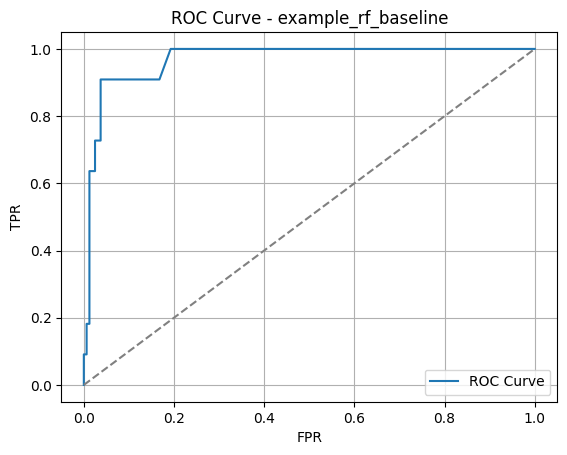

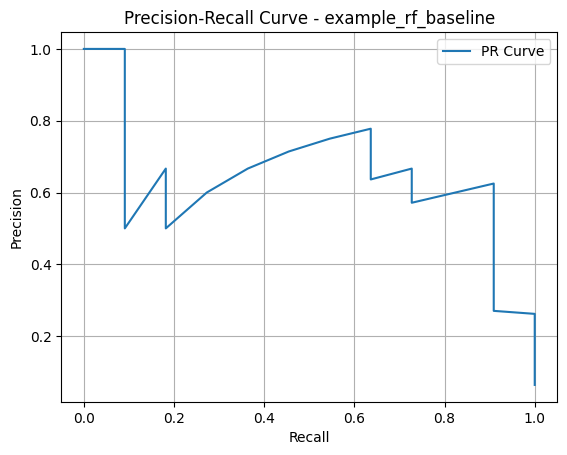

In [35]:
def plot_curves(model, model_name='model'):
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0,1],[0,1],'--', color='gray')  # baseline
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
    plt.legend()
    plt.show()   # <--- display in notebook
    plt.savefig(OUT_DIR / f'roc_{model_name}.png')
    plt.close()
    
    # PR Curve
    plt.figure()
    plt.plot(recall, precision, label='PR Curve')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    plt.show()   # <--- display in notebook
    plt.savefig(OUT_DIR / f'pr_{model_name}.png')
    plt.close()
    
plot_curves(best_model, model_name='example_rf_baseline')